# Particle settling velocity in quiescent fluid

by Xiaofeng Liu, Ph.D., P.E.
Associate Professor

Department of Civil and Environmental Engineering

Institute of Computational and Data Sciences

Penn State University

223B Sackett Building, University Park, PA 16802

Web: http://water.engr.psu.edu/liu/
____________________________________________________


## Introduction
This notebook demonstrates the calculation of terminal settling velocity of a single partilce in quiescent fluid. Settling velocity of a particle is a very important quantify for many problems in water resources engineering and environmental engineering. For example, how fast sediment particles settle will affect their transport in rivers and their impact on water quality. Another example is settling tank in wastewater treatment plant. The settling velocity of particles in the treated wastewater directly affects the size of settling tank. 

## Terminal settling velocity formula
In this example, the particle settles freely in a water tank (Figure 1). 

<img src="1D_settling.png" width=400/>


<h3 align="center">Figure 1. One-dimensional (vertical) settling of a particle in quiescent fluid.</h3> 

The initial position of the particle is $y(t=0)$ = 0.495 m and the initial velocity is 0 m/s. After initial release, the particle accelerates under the influence of gravity and then asymptotically approaches its terminal velocity when the drag force gradually increases. At steady state, the force balance should be
\begin{equation}
F_D + F_B = G
\end{equation}
where $F_D$ is the drag force, $F_B$ is the buoyancy force, and $G$ is the gravity force. The combination of gravity and buoyancy forces can be written as
\begin{equation}
G-F_B = \left(\rho_p - \rho_f \right)\frac{4}{3} \pi r^3 g
\end{equation}
The drag force can be evaluated semi-empirically using the drag coefficient
\begin{equation}
F_D = C_D \frac{1}{2}\rho_f W^2 A   \quad \mbox{or} \quad C_D = \frac{F_D}{\frac{1}{2}\rho_f W^2 A}
\end{equation}
One can also define the particle Reynolds number as 
\begin{equation}
Re = \frac{WD}{\nu}
\end{equation}
where $W$ is the terminal settling velocity, $\nu$ is the fluid kinematic viscosity. The drag coefficient $C_D$ can be evaluated with empirical formulas. For spheres, we can use the following drag coefficient formula which separates the laminar and turbulent regimes
\begin{equation}
   C_D= 
\begin{cases}
    0.424,& \text{if } Re > 1000\\
    \frac{24}{Re}\left(1.0 + \frac{1}{6}Re^{\frac{2}{3}} \right),              & \text{otherwise}
\end{cases}
\end{equation}
There are also other formulas which aim for a unified formula for spheres. For example, Morrison (2013) proposed a formula which captures the drag coefficient as a function of the particle Reynolds number over the entire range available experimental data:
\begin{equation}
C_D = \frac{24}{Re} + \frac{2.6\left(\frac{Re}{5.0} \right)}{1+\left(\frac{Re}{5.0} \right)^{1.52}} + \frac{0.411 \left(\frac{Re}{2.63 \times 10^5} \right)^{-7.94}}{1+\left(\frac{Re}{2.63\times10^5} \right)^{-8.00}} + \frac{0.25 \left(\frac{Re}{10^6} \right)}{1+\left(\frac{Re}{10^6} \right)}
\end{equation}

When the particle reaches terminal settling velocity, the force balance can then be written as
\begin{equation}
C_D \frac{1}{2}\rho_f W^2 A = \left(\rho_p - \rho_f \right)\frac{4}{3} \pi r^3 g
\end{equation}
which is am implicit function of the terminal settling velocity $W$ if everything else is given. The solution of $W$ nees to find the root of the following function
\begin{equation}
f(W) = C_D(W) \frac{1}{2}\rho_f W^2 A - \left(\rho_p - \rho_f \right)\frac{4}{3} \pi r^3 g
\end{equation}

This example notebook uses this webpage as a reference: [hinderedsettling.com](https://hinderedsettling.com/2013/08/09/grain-settling-python/).

More resources can be found online:
* [wikipedia.org](https://en.wikipedia.org/wiki/Settling)
* [Garcia (2008), "Sedimentaion Engineering", Chapter 2](https://ascelibrary.org/doi/book/10.1061/9780784408148)
* Ferguson, R. and Church, M. (2004) A simple universal equation for grain settling velocity. Journal of Sedimentary Research 74, 933–937.

The following concetps in Python are used:
* function
* Numpy array
* plotting and graphic visulization

Note: This notebook uses Python v3.x. 

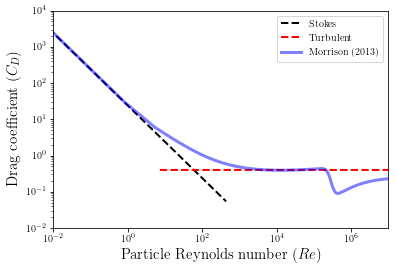

In [3]:
#make plots inline
%matplotlib inline

import numpy as np
import operator
import csv
from numpy import loadtxt,pi,sqrt
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.signal import savgol_filter
from scipy.optimize import fsolve
import os

rop = 2650.0 # density of particle in kg/m3
rof = 1000.0 # density of fluid in kg/m3
visc = 1.002*1E-3 # dynamic viscosity in Pa*s (N*s/m^2)
g = 9.81  #gravity constant
C1 = 18 # constant in Ferguson-Church equation
C2 = 1 # constant in Ferguson-Church equation, valid for natural sand grains

def v_stokes(rop,rof,d,visc,C1):
        R = (rop-rof)/rof # submerged specific gravity
        w = R*9.81*(d**2)/(C1*visc/rof)
        return w

def v_turbulent(rop,rof,d,visc,C2):
        R = (rop-rof)/rof 
        w = (4*R*9.81*d/(3*C2))**0.5
        return w

def v_ferg(rop,rof,d,visc,C1,C2):
        R = (rop-rof)/rof 
        w = (R*9.81*d**2)/(C1*visc/rof+(0.75*C2*R*9.81*d**3)**0.5)
        return w

def Cd_Morrison(Re):
        w = 24.0/Re + 2.6*(Re/5.0)/(1.+(Re/5.0)**1.52) + 0.411*(Re/2.63e5)**(-7.94)/(1.+(Re/2.63e5)**(-8.0)) + 0.25*(Re/1e6)/(1+Re/1e6)
        return w    

def v_Morrison(Vt, *data):
    rop,rof,d_p,g,visc = data
    Re=rof*Vt*d_p/visc
    return sqrt((4*g*(rop - rof)*d_p)/(3*Cd_Morrison(Re)*rof)) - Vt

 
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Set the font dictionaries (for plot title and axis titles)
title_font = {'fontname':'Arial', 'size':'16', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'fontname':'Serif', 'size':'14'}

fig = plt.figure()
ax = fig.add_subplot(111)

d = np.arange(0.000001,2,0.0001)
dStokes = np.arange(0.000001,0.0008,0.00001)
dTurbulent = np.arange(0.0001,2,0.00001)
C2 = 0.4 # this constant is 0.4 for spheres, 1 for natural grains
ws = v_stokes(rop,rof,dStokes,visc,C1)
wt = v_turbulent(rop,rof,dTurbulent,visc,C2)
wf = v_ferg(rop,rof,d,visc,C1,C2)

FdStokes = (rop-rof)*4/3*pi*((dStokes/2)**3)*9.81 # drag force
FdTurbulent = (rop-rof)*4/3*pi*((dTurbulent/2)**3)*9.81 # drag force
FdFurguson = (rop-rof)*4/3*pi*((d/2)**3)*9.81 # drag force
Cds = FdStokes/(rof*ws**2*pi*(dStokes**2)/8) # drag coefficient
Cdt = FdTurbulent/(rof*wt**2*pi*(dTurbulent**2)/8)
Cdf = FdFurguson/(rof*wf**2*pi*(d**2)/8)
Res = rof*ws*dStokes/visc # particle Reynolds number
Ret = rof*wt*dTurbulent/visc
Ref = rof*wf*d/visc

#drag coefficient due to Morrosion (2013)
Cdm = Cd_Morrison(Ref)

plt.loglog(Res,Cds,color='k',linewidth=2, linestyle='--', label='Stokes')
plt.loglog(Ret,Cdt,color='r',linewidth=2, linestyle='--', label='Turbulent')
#plt.loglog(Ref,Cdf,linewidth=3, label='Ferguson-Church')
plt.loglog(Ref,Cdm,color='b',alpha=0.5,linewidth=3, label='Morrison (2013)')

plt.legend(loc=1)
plt.axis([1e-2,1e7,1e-2,1e4])
plt.xlabel('Particle Reynolds number ($Re$)', fontsize=15)
plt.ylabel('Drag coefficient ($C_D$)', fontsize=15)

plt.savefig('drag_coeff.png',dpi=300,bbox_inches='tight', pad_inches=0)

plt.show()

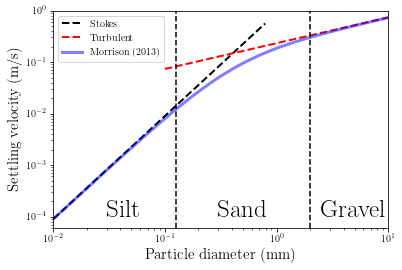

In [2]:
d = np.arange(0,0.01,0.00001)
ws = v_stokes(rop,rof,dStokes,visc,C1)
wt = v_turbulent(rop,rof,dTurbulent,visc,C2)
wf = v_ferg(rop,rof,d,visc,C1,C2)

fig = plt.figure()
ax = fig.add_subplot(111)

plt.loglog(dStokes*1000,ws,label='Stokes',color='k',linewidth=2, linestyle='--',)
plt.loglog(dTurbulent*1000,wt,'g',label='Turbulent',color='r',linewidth=2, linestyle='--')
plt.loglog(d*1000,wf,'r',label='Morrison (2013)',color='b',alpha=0.5,linewidth=3)
plt.text(0.03, 0.0001, 'Silt', fontsize=25)
plt.plot([1.0/8, 1.0/8],[0.00001, 10],'k--')
plt.plot([2, 2],[0.00001, 10],'k--')
plt.text(0.3, 0.0001, 'Sand', fontsize=25)
plt.text(2.5, 0.0001, 'Gravel', fontsize=25)

plt.legend(loc=2)
plt.xlabel('Particle diameter (mm)', fontsize=15)
plt.ylabel('Settling velocity (m/s)', fontsize=15)
plt.xlim(0.01,10)
plt.ylim(6e-5,1)

plt.legend(loc='upper left')
plt.savefig('1D_settling_velocity.png',dpi=300,bbox_inches='tight', pad_inches=0)
plt.show()